computing minhash: 100%|██████████| 1200/1200 [01:58<00:00, 10.12it/s]


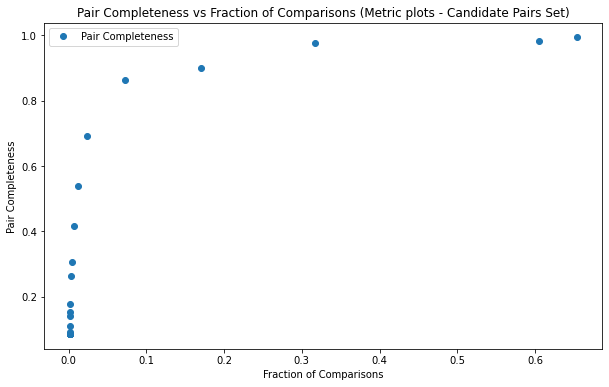

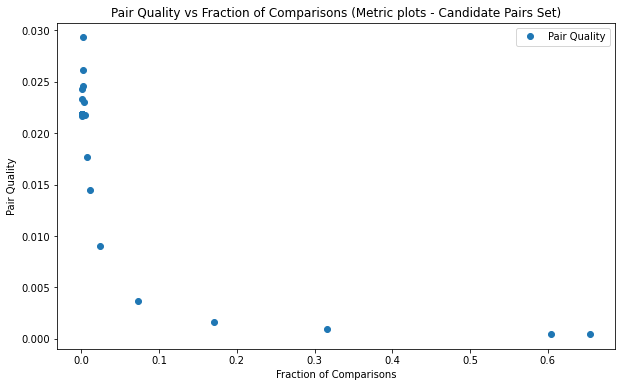

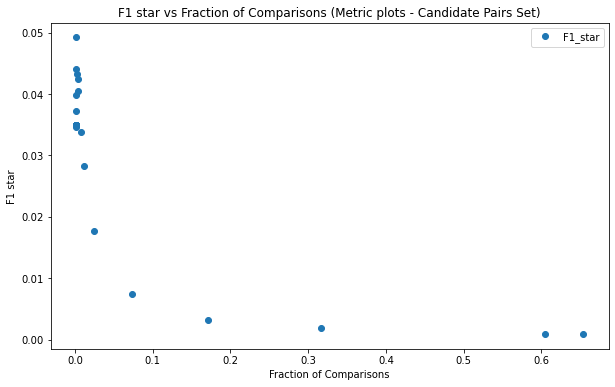

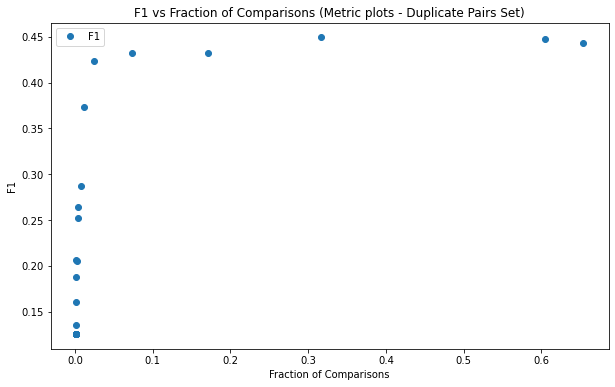

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import json
import sympy
import re
import itertools
import collections
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from random import shuffle
from tqdm import tqdm
from itertools import combinations
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

with open('TVs-all-merged.json', 'r') as file:
    json_data = json.load(file)

def get_brand(title): # Function to extract brand from the product description
    # List of TV brand names found on the internet to assign to the products
    brands_possible = ["Apple", "Affinity", "Avue", "Azend", "Coby", "Contex", "Compaq", "Craig", "CurtisYoung", "Elite", "Elo", "Epson", "GPX", "Haier", "Hannspree", "Hello Kitty", "HP", "Dynex", "Hisense", "Hiteker", "Insignia", "JVC", "LG", "Magnavox", "Mitsubishi", "Naxa", "NEC", "Optoma", "Panasonic", "Philips", "ProScan", "Sceptre", "Pyle", "RCA", "Sanyo", "Sansui", "Seiki", "Sony", "Samsung", "Sigmac", "Sharp", "SunBriteTV", "SuperSonic", "TCL", "Toshiba", "UpStar", "Venturer", "Vizio", "ViewSonic", "Viore", "Westinghouse"]
    
    # Check if any brand name is present in the title
    matching_brands = [brand for brand in brands_possible if brand.lower() in title.lower()]
    
    # If a matching brand is found, return the first one; otherwise, return None
    return matching_brands[0] if matching_brands else None


def get_inch(a):
    norm_inch = ['Inch', 'inches', '"', '-inch', ' inch', 'inch ', 'INCH', '-Inch', '”', "'"]
    for x in norm_inch:
        if x in a:
            a = a.replace(x, "inch ")
    return a


def get_hz(a):
    norm_hz = ['Hertz','HZ','Hz', ' hz', '-hz', 'hz' ]
    for x in norm_hz:
        if x in a:
            a = a.replace(x, "hz " )
    return a  


def clean_title(title): # Function to clean the title by removing spaces and non-alphanumeric tokens in front of units
    if isinstance(title, str):
        units = ['inch', 'hz']
        for unit in units:
            pattern = re.compile(rf'[^a-zA-Z0-9]{{0,}}{re.escape(unit)}', re.IGNORECASE)
            title = re.sub(pattern, unit, title)
        return title
    else:
        return title

def convert_dict_to_lowercase(input_dict):
    # Create a new dictionary with lowercase keys and values
    lowercase_dict = {key.lower(): value.lower() if isinstance(value, str) else value for key, value in input_dict.items()}
    return lowercase_dict

def convert_to_lowercase(input_string):
    return input_string.lower()

def extract_model_words(value, pattern):
    if isinstance(value, dict):
        # Extract values from the dictionary and join them into a string
        value_str = ' '.join(str(v) for v in value.values())
        # Apply the regular expression to the joined string
        return pattern.findall(value_str)
    return []

def generate_binary_vectors(MW_title, title, MW):
    binary_vectors = []

    for i, sublist in tqdm(enumerate(MW_title), desc="Generating binary vectors", total=len(MW_title)):
        binary_vector = []
        for word in MW:
            if word in title.iloc[i]:
                binary_vector.append(1)
            else:
                binary_vector.append(0)
                
        binary_vectors.append(binary_vector)

    return binary_vectors

def create_hash_function(size):
    return lambda x: mmh3.hash(x) % size

def build_minhash_func(MW_size: int, nbits: int):
    # function for building multiple minhash vectors
    hashes = []
    for _ in range(nbits):
        hashes.append(create_hash_function(MW_size))
    return hashes

def create_hash(vector: list):
    signature = []
    for func in minhash_func:
        for i in range(1, len(MW)+1):
            id_MW = func.index(i)
            signature_value = vector[id_MW]
            if signature_value == 1:
                signature.append(id_MW)
                break
    return signature

def minHash(binary_matrix, num_minhashes):
    nModelWords, nProducts = binary_matrix.shape
    S = np.empty((num_minhashes, nProducts), int)

    for idx in tqdm(range(num_minhashes), desc='computing minhash'):
        permutation = np.random.permutation(nModelWords)
        for prod in range(nProducts):
            # Finding the index of the first '1' in the permuted order
            for perm in permutation:
                if binary_matrix[perm][prod] == 1:
                    S[idx][prod] = perm + 1
                    break
    return S

def jaccard(x, y):
    intersection_size = len(set(x).intersection(y))
    union_size = len(set(x).union(y))
    return intersection_size / union_size if union_size != 0 else 0

def split_into_bands(signature_matrix, b):
    n_rows, n_cols = signature_matrix.shape
    band_size = n_rows // b

    bands = []
    for band_index in range(b):
        start_row = band_index * band_size
        end_row = (band_index + 1) * band_size
        band = signature_matrix[start_row:end_row, :]
        bands.append(band)

    return bands

def identify_candidate_pairs(hash_table):
    # Identify candidate pairs
    candidate_pairs = set()
    for bucket in hash_table.values():
        if len(bucket) > 1:
            # Add pairs of products in the same bucket as candidate neighbors
            candidate_pairs.update(combinations(bucket, 2))
    
    candidate_pairs = remove_duplicates(candidate_pairs)
    return candidate_pairs

def ordered_pairs(candidate_pairs):
    ordered_pairs = set()

    for pair in candidate_pairs:
        # Ensure the pair is in ascending order
        ordered_pair = tuple(sorted(pair))
        
        # Add the ordered pair to the result set
        ordered_pairs.add(ordered_pair)

    return ordered_pairs

def is_prime(number):
    if number < 2:
        return False
    for i in range(2, int(number**0.5) + 1):
        if number % i == 0:
            return False
    return True

def locality_sensitive_hashing(signature_matrix, b, r):
    
    n, products = signature_matrix.shape

    hash_table = collections.defaultdict(list)
    candidate_pairs = set()

    for band_index in range(b):
        band = signature_matrix[band_index * r: (band_index + 1) * r, :]

        for product_index in range(products):
            hash_value = tuple(band[:, product_index])
            hash_table[hash_value].append(product_index)

    candidate_pairs = identify_candidate_pairs(hash_table)

    return candidate_pairs

def remove_duplicates(candidate_pairs):
    seen_pairs = set()
    unique_pairs = set()

    for pair in candidate_pairs:
        # Convert the pair to a frozenset to make it hashable
        hashable_pair = frozenset(pair)

        # Check if the pair is already seen
        if hashable_pair not in seen_pairs:
            seen_pairs.add(hashable_pair)
            unique_pairs.add(pair)

    return unique_pairs

def candidate_pairs_cleaner(candidate_pairs, df):
    cleaned_pairs = []
    
    for pair in candidate_pairs:
        index1, index2 = pair
        brand1 = df.loc[index1, 'Brand']
        brand2 = df.loc[index2, 'Brand']
        shop1 = df.loc[index1, 'shop']
        shop2 = df.loc[index2, 'shop']
        
        if brand1 == brand2 and shop1 != shop2:
            cleaned_pairs.append(pair)
    
    return cleaned_pairs

def calculate_jaccard_similarity(pair, df):
    index1, index2 = pair
    title1 = set(df.loc[index1, 'title'].split())
    title2 = set(df.loc[index2, 'title'].split())
    
    return jaccard(title1, title2)

def title_similarity(model_words1, model_words2):
    jaccard_similarity = jaccard(model_words1, model_words2)
    return jaccard_similarity

def dissimilarity_matrix(candidate_pairs, df, MW_title):
    num_products = len(df)
    dissimilarity_matrix = np.full((num_products, num_products), np.inf)

    for pair in candidate_pairs:
        index1, index2 = pair
        brand1 = df.loc[index1, 'Brand']
        brand2 = df.loc[index2, 'Brand']
        shop1 = df.loc[index1, 'shop']
        shop2 = df.loc[index2, 'shop']

        if brand1 == brand2 and shop1 != shop2:
            model_words1 = set(MW_title[index1])
            model_words2 = set(MW_title[index2])

            jaccard_similarity = title_similarity(model_words1, model_words2)
            dissimilarity_matrix[index1, index2] = 1 - jaccard_similarity
            dissimilarity_matrix[index2, index1] = dissimilarity_matrix[index1, index2]

    # Replace NaN and infinity values with a large positive number
    dissimilarity_matrix[np.isnan(dissimilarity_matrix)] = 1e6
    dissimilarity_matrix[np.isinf(dissimilarity_matrix)] = 1e6

    return dissimilarity_matrix


def linkage_clustering(dissimilarity_matrix, threshold):
    n_products = len(dissimilarity_matrix)

    # Initialize AgglomerativeClustering with precomputed dissimilarity matrix
    clustering = AgglomerativeClustering(n_clusters=None, affinity="precomputed", linkage='complete', distance_threshold=threshold)

    # Fit the clustering model
    clusters = clustering.fit_predict(dissimilarity_matrix)

    # Mapping product indices to cluster labels
    clusters_dict = {}
    for idx, cluster_label in enumerate(clusters):
        if cluster_label not in clusters_dict:
            clusters_dict[cluster_label] = [idx]
        else:
            clusters_dict[cluster_label].append(idx)

    # Extract duplicate pairs from the clusters
    duplicate_pairs = []
    for cluster_indices in clusters_dict.values():
        if len(cluster_indices) > 1:
            duplicate_pairs.extend([(i, j) for i in cluster_indices for j in cluster_indices if i < j])

    return duplicate_pairs

def identify_duplicate_pairs(df):
    model_pairs_dict = {}

    for index, modelID in enumerate(df['modelID']):
        model_pairs_dict.setdefault(modelID, []).append(index)

    duplicates = {pair for val in model_pairs_dict.values() if len(val) > 1 for pair in itertools.combinations(val, 2)}
    duplicates = remove_duplicates(duplicates)

    return duplicates
    
def split_data(df):
    X = df.copy()
    y = pd.Series(1, index=df.index)
    # Split the data into 63% training and 37% testing
    X_train, _, _, _ = train_test_split(X, y, test_size=0.37)

    # You can return the resulting DataFrame if needed
    return X_train

def plot_metrics(metrics_results, plot_title):
    # Store results for plotting
    fraction_of_comparisons_values_candidate_pairs = []
    pair_completeness_values_candidate_pairs = []
    pair_quality_values_candidate_pairs = []
    f1_star_values_candidate_pairs = []
    f1_values_candidate_pairs = []

    f1_values_duplicate_pairs = []

    for outer_list in metrics_results:
        for r, metrics_array_candidate_pairs, F1 in outer_list:
            pair_completeness_values_candidate_pairs.append(metrics_array_candidate_pairs[0])
            pair_quality_values_candidate_pairs.append(metrics_array_candidate_pairs[1])
            f1_star_values_candidate_pairs.append(metrics_array_candidate_pairs[2])
            fraction_of_comparisons_values_candidate_pairs.append(metrics_array_candidate_pairs[3])

            f1_values_duplicate_pairs.append(F1)

    # Plot metrics for candidate_pairs_set
    plt.figure(figsize=(10, 6))
    plt.plot(fraction_of_comparisons_values_candidate_pairs, pair_completeness_values_candidate_pairs, marker='o', linestyle='None', label='Pair Completeness')
    plt.xlabel('Fraction of Comparisons')
    plt.ylabel('Pair Completeness')
    plt.title(f'Pair Completeness vs Fraction of Comparisons ({plot_title} - Candidate Pairs Set)')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(fraction_of_comparisons_values_candidate_pairs, pair_quality_values_candidate_pairs, marker='o', linestyle='None', label='Pair Quality')
    plt.xlabel('Fraction of Comparisons')
    plt.ylabel('Pair Quality')
    plt.title(f'Pair Quality vs Fraction of Comparisons ({plot_title} - Candidate Pairs Set)')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(fraction_of_comparisons_values_candidate_pairs, f1_star_values_candidate_pairs, marker='o', linestyle='None', label='F1_star')
    plt.xlabel('Fraction of Comparisons')
    plt.ylabel('F1 star')
    plt.title(f'F1 star vs Fraction of Comparisons ({plot_title} - Candidate Pairs Set)')
    plt.legend()
    plt.show()

    # Plot metrics for duplicate_pairs_set
    plt.figure(figsize=(10, 6))
    plt.plot(fraction_of_comparisons_values_candidate_pairs, f1_values_duplicate_pairs, marker='o', linestyle='None', label='F1')
    plt.xlabel('Fraction of Comparisons')
    plt.ylabel('F1')
    plt.title(f'F1 vs Fraction of Comparisons ({plot_title} - Duplicate Pairs Set)')
    plt.legend()
    plt.show()

def calculate_metrics_for_r_values(r_values, signature_matrix, ID_duplicates, N, df, MW_title):
    metrics_results = []

    for r in r_values:
        
        # Calculate candidate pairs for the current r
        candidate_pairs = locality_sensitive_hashing(signature_matrix, max(1, int(signature_matrix.shape[0] // r)), r)
        candidate_pairs = ordered_pairs(candidate_pairs) ###
        diss_matrix = dissimilarity_matrix(candidate_pairs, df, MW_title)
        
        threshold = 0.5  # Adjust this threshold value accordingly
        duplicate_pairs = linkage_clustering(diss_matrix, threshold)
        duplicate_pairs = ordered_pairs(duplicate_pairs)
        duplicate_pairs_set = set(duplicate_pairs)
        
        # Transform candidate_pairs to a set
        candidate_pairs_set = set(candidate_pairs)
        
        # Calculate metrics for the current r using candidate pairs
        metrics_array_candidate_pairs = calculate_metrics(ID_duplicates, candidate_pairs_set, N)

        F1 = calculate_f1(ID_duplicates, duplicate_pairs_set)
        
        # Store the results
        metrics_results.append((r, metrics_array_candidate_pairs, F1))
        
    return metrics_results

def calculate_metrics(ID_duplicates, candidate_pairs, N):
    FP = list(candidate_pairs - ID_duplicates)
    TP = list(candidate_pairs - set(FP))
    FN = list(ID_duplicates - candidate_pairs)

    recall_denominator = len(TP) + len(FN)
    recall = len(TP) / recall_denominator if recall_denominator != 0 else 0
    
    precision_denominator = len(TP) + len(FP)
    precision = len(TP) / precision_denominator if precision_denominator != 0 else 0
    
    pair_completeness_denominator = len(ID_duplicates)
    pair_completeness = len(TP) / pair_completeness_denominator if pair_completeness_denominator != 0 else 0

    pair_quality_denominator = len(candidate_pairs)
    pair_quality = len(TP) / pair_quality_denominator if pair_quality_denominator != 0 else 0
    
    f1_denominator = precision + recall
    F1 = (2 * precision * recall) / f1_denominator if f1_denominator != 0 else 0

    f1_star_denominator = pair_quality + pair_completeness
    F1_star = (2 * pair_quality * pair_completeness) / f1_star_denominator if f1_star_denominator != 0 else 0
    
    fraction_of_comparisons = len(candidate_pairs) / (N * (N - 1) / 2)

    metrics_array = [pair_completeness, pair_quality, F1_star, fraction_of_comparisons]
    return metrics_array

def calculate_f1(ID_duplicates, candidate_pairs):
    FP = list(candidate_pairs - ID_duplicates)
    TP = list(candidate_pairs - set(FP))
    FN = list(ID_duplicates - candidate_pairs)

    recall_denominator = len(TP) + len(FN)
    recall = len(TP) / recall_denominator if recall_denominator != 0 else 0
    
    precision_denominator = len(TP) + len(FP)
    precision = len(TP) / precision_denominator if precision_denominator != 0 else 0
    
    f1_denominator = precision + recall
    F1 = (2 * precision * recall) / f1_denominator if f1_denominator != 0 else 0
    
    return F1

def run_algorithm(df, nBootstraps):

    metrics_results = []
    
    for i in range(nBootstraps):
        with open('TVs-all-merged.json', 'r') as file:
            json_data = json.load(file)
        
        df_list = []

        for model_id, details_list in json_data.items():
            for details in details_list:
                details["modelID"] = model_id
                df_list.append(details)

        df = pd.DataFrame(df_list)
        df = df.drop('url', axis=1)
        
        df = split_data(df)
        df = df.reset_index(drop=True)

        df['Brand'] = df['title'].apply(get_brand)
        df['title'] = df['title'].apply(get_inch)
        df['title'] = df['title'].apply(get_hz)
        df['title'] = df['title'].apply(convert_to_lowercase)
        df['title'] = df['title'].apply(clean_title)

        df['featuresMap'] = df['featuresMap'].apply(lambda x: {key: get_inch(value) for key, value in x.items()})
        df['featuresMap'] = df['featuresMap'].apply(get_hz)
        df['featuresMap'] = df['featuresMap'].apply(convert_dict_to_lowercase)
        df['featuresMap'] = df['featuresMap'].apply(clean_title)

        shop = df['shop']
        modelID = df['modelID']
        featuresMap = df['featuresMap']
        title = df['title']
        brands = df['Brand']

        # Define the regular expression for model words
        MW_title_pattern = re.compile(r'([a-zA-Z0-9]*(([0-9]+[^0-9, ]+)|([^0-9, ]+[0-9]+))[a-zA-Z0-9]*)')

        # Extract model words from 'title' column
        MW_title_full = df['title'].apply(lambda x: MW_title_pattern.findall(str(x)) if isinstance(x, str) else [])

        # Extract the first element of each tuple
        MW_title_part1 = [[item[0] for item in row] for row in MW_title_full]

        # Add brand to each row (if available) and filter out rows with missing brand
        MW_title = [
            part1 + [brand] if brand is not None else part1 
            for part1, brand in zip(MW_title_part1, df['Brand'])
        ]
        
        ID_duplicates = identify_duplicate_pairs(df)
        ID_duplicates = ordered_pairs(ID_duplicates)
        ID_duplicates = set(ID_duplicates)
        
        binary_matrix = generate_binary_vectors(MW_title, title, MW)
        binary_matrix_rows_np = np.array(binary_matrix)
        binary_matrix_np = np.transpose(binary_matrix_rows_np)
        num_minhashes = 1200
        minhash_func = build_minhash_func(len(binary_matrix_np[:, 0]), num_minhashes)

        nModelWords, nProducts = binary_matrix_np.shape
        S = np.empty((num_minhashes, nProducts), int)
        signature_matrix = minHash(binary_matrix_np, num_minhashes)
        
        n = signature_matrix.shape[0]
        
        r_values = [2, 3, 4, 5, 6, 8, 10, 12, 15, 16, 20, 24, 25, 30, 40, 48, 50, 60, 75, 80, 100, 120, 150, 200, 240, 300, 400, 600]

        
        N = len(df)
        metrics_results.append(calculate_metrics_for_r_values(r_values, signature_matrix, ID_duplicates, N, df, MW_title))

    return metrics_results


#--------------------------------------------[Initialization]------------------------------------#

with open('TVs-all-merged.json', 'r') as file:
            json_data = json.load(file)
        
df_list = []

for model_id, details_list in json_data.items():
    for details in details_list:
        details["modelID"] = model_id
        df_list.append(details)

df = pd.DataFrame(df_list)
df = df.drop('url', axis=1)
        
df = split_data(df)
df = df.reset_index(drop=True)

df['Brand'] = df['title'].apply(get_brand)
df['title'] = df['title'].apply(get_inch)
df['title'] = df['title'].apply(get_hz)
df['title'] = df['title'].apply(convert_to_lowercase)
df['title'] = df['title'].apply(clean_title)

df['featuresMap'] = df['featuresMap'].apply(lambda x: {key: get_inch(value) for key, value in x.items()})
df['featuresMap'] = df['featuresMap'].apply(get_hz)
df['featuresMap'] = df['featuresMap'].apply(convert_dict_to_lowercase)
df['featuresMap'] = df['featuresMap'].apply(clean_title)

shop = df['shop']
modelID = df['modelID']
featuresMap = df['featuresMap']
title = df['title']
brands = df['Brand']

# Define the regular expression for model words
MW_title_pattern = re.compile(r'([a-zA-Z0-9]*(([0-9]+[^0-9, ]+)|([^0-9, ]+[0-9]+))[a-zA-Z0-9]*)')

# Extract model words from 'title' column
MW_title_full = df['title'].apply(lambda x: MW_title_pattern.findall(str(x)) if isinstance(x, str) else [])

# Extract the first element of each tuple
MW_title_part1 = [[item[0] for item in row] for row in MW_title_full]

# Add brand to each row (if available) and filter out rows with missing brand
MW_title = [
    part1 + [brand] if brand is not None else part1 
    for part1, brand in zip(MW_title_part1, df['Brand'])
]

MW = set()  # Set to store all model words
binary_vectors = []

for sublist in MW_title:
    for word in sublist:
        if word not in MW:
            MW.add(word)

#---------------------------------------------------------------------------------------------------------------------#            
            
metrics_results = run_algorithm(df, nBootstraps = 1)
plot_metrics(metrics_results, 'Metric plots')